In [1]:
import os 
import csv
import matplotlib
import pandas as pd
import random
import re
import html
import math
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import math
import seaborn as sns
from email import message_from_string
import nltk

In [2]:
from nltk.corpus import stopwords
nltk.download("stopwords")

STOPWORDS = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##  Importing Dataset TREC06 Corpus
We use the TREC06 Public Spam Corpus which is a dataset for benchmarking spam algorithms. But first we check the emails and how different it is from one another or how noisy it is.

In [3]:
def load_trec06p_dataset(base_path):
    labels_file = os.path.join(base_path, "labels")
    raw_data, labels = [], []

    with open(labels_file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2:
                continue
            label, rel_path = parts
            rel_path = rel_path.replace("../", "")
            file_path = os.path.join(base_path, rel_path)

            # Read as raw bytes to preserve original encoding
            with open(file_path, "rb") as email_file:
                raw_bytes = email_file.read()
            
            # Store raw bytes - let tokenizer handle decoding
            raw_data.append(raw_bytes)
            labels.append(label.lower())

    return raw_data, labels

In [4]:
data,labels = load_trec06p_dataset("./trec06p/")

## Training/Test Set Splitting (70/30)
We split the training and test set by 70-30. 

In [5]:
random.seed(42)
combined = list(zip(data, labels))
random.shuffle(combined)

split = int(0.7 * len(combined))
train_set, test_set = combined[:split], combined[split:]

train_texts, train_labels = zip(*train_set)
test_texts, test_labels = zip(*test_set)

train_counts = Counter(train_labels)
print("Training set counts:", train_counts)
print("Spam in training:", train_counts["spam"])
print("Ham in training:", train_counts["ham"])

test_counts = Counter(test_labels)
print("\nTest set counts:", test_counts)
print("Spam in test:", test_counts["spam"])
print("Ham in test:", test_counts["ham"])

Training set counts: Counter({'spam': 17353, 'ham': 9122})
Spam in training: 17353
Ham in training: 9122

Test set counts: Counter({'spam': 7559, 'ham': 3788})
Spam in test: 7559
Ham in test: 3788


## Training and Test Set

This section handles the saving of training and test set. It wont be changing its test and training set.Run this code to save and import a csv for the set needed to run this code.

In [6]:
import base64
import pandas as pd

def save_splits(train_texts, train_labels, test_texts, test_labels,
                train_path="train_set.csv.gz", test_path="test_set.csv.gz"):
    # Encode each raw byte email to Base64 text
    train_b64 = [base64.b64encode(x).decode("ascii") for x in train_texts]
    test_b64  = [base64.b64encode(x).decode("ascii") for x in test_texts]

    train_df = pd.DataFrame({"text_b64": train_b64, "label": train_labels})
    test_df  = pd.DataFrame({"text_b64": test_b64, "label": test_labels})

    # Save with gzip compression
    train_df.to_csv(train_path, index=False, encoding="utf-8", compression="gzip")
    test_df.to_csv(test_path,  index=False, encoding="utf-8", compression="gzip")

    print(f"Saved {len(train_df)} training samples to {train_path}")
    print(f"Saved {len(test_df)} test samples to {test_path}")


In [7]:
save_splits(train_texts, train_labels, test_texts, test_labels,train_path="train_set.csv.gz", test_path="test_set.csv.gz")

Saved 26475 training samples to train_set.csv.gz
Saved 11347 test samples to test_set.csv.gz


## Loading of Training and Test Set
Just run the load_splits  and it will load the training and test set.

In [11]:
def load_splits(train_path="train_set.csv.gz", test_path="test_set.csv.gz"):
    import base64, pandas as pd
    
    # Read CSVs with gzip compression
    train_df = pd.read_csv(train_path, compression="gzip")
    test_df  = pd.read_csv(test_path,  compression="gzip")

    # Decode Base64 back to bytes
    train_texts  = [base64.b64decode(x) for x in train_df["text_b64"]]
    test_texts   = [base64.b64decode(x) for x in test_df["text_b64"]]
    train_labels = list(train_df["label"])
    test_labels  = list(test_df["label"])

    return train_texts, train_labels, test_texts, test_labels


In [12]:
# Load back the preprocessed splits
train_texts, train_labels, test_texts, test_labels = load_splits(
    train_path="train_set.csv.gz",
    test_path="test_set.csv.gz"
)

# Check a sample
print(len(train_texts), "training emails loaded")
print(len(test_texts),  "test emails loaded")
print(type(train_texts[0]))
print(train_labels[:5])

26475 training emails loaded
11347 test emails loaded
<class 'bytes'>
['ham', 'ham', 'ham', 'spam', 'spam']


## Tokenizing For Classifier
We need to create a set of vocabulary of words and to do that we need to tokenize each email and get the unique set of words. This will be improved later on.

In [8]:
def tokenize(text):
    # Convert to string if bytes
    if isinstance(text, bytes):
        text = text.decode('utf-8', errors='ignore')

    text = text.lower()

    # ---- Cleaning ----
    text = re.sub(r'<[^>]+>', ' ', text) 
    text = html.unescape(text)
    text = re.sub(r'[a-z0-9+/]{50,}={0,2}', ' ', text)     # remove base64 blocks
    text = re.sub(r'\b\d{1,3}(?:\.\d{1,3}){3}\b', ' ', text) # remove IPs
    text = re.sub(r'<[^>]+@[^>]+>', ' ', text)      # remove message IDs/emails
    text = re.sub(r'\b[a-f0-9]{20,}\b', ' ', text)  # remove long hex strings
    text = re.sub(r'https?://[^\s]+', ' ', text)    # remove URLs
    text = re.sub(r'www\.[^\s]+', ' ', text)

    # Remove all symbols and punctuation (hyphens will be treated as separators)
    text = re.sub(r'[^a-z\s]+', ' ', text)

    # Remove single letters and normalize whitespace
    text = re.sub(r'\b[a-z]\b', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # ---- Token extraction ----
    word_tokens = re.findall(r'[a-z]{2,}', text)    # plain words only
    word_tokens = [t for t in word_tokens if 2 <= len(t) <= 30]
    
    # Remove stopwords
    word_tokens = [t for t in word_tokens if t not in STOPWORDS]

    return word_tokens


## Vocabulary of Words

We use the tokenize function to create a vocabulary of words and count how many vocab of words that are unique to the training set.

In [13]:
vocab = set()
for i, text in enumerate(train_texts):
    vocab.update(tokenize(text))

vocab_list = sorted(vocab)

In [14]:
print("First 100 vocab words:\n")
print(vocab_list[:100])

print("\nTotal vocab size:", len(vocab_list))
print("Unique check:", len(vocab_list) == len(set(vocab_list)))

First 100 vocab words:

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaag', 'aaaaaaaaaaaaaaaaaaeaaadqaaca', 'aaaaaaaaaaaaaadh', 'aaaaaaaaaaaaandp', 'aaaaaaacp', 'aaaaaaiee', 'aaaaaaiey', 'aaaaabaaaadwaaaacaaaagqaaaaa', 'aaaaacqk', 'aaaaaeaaieaa', 'aaaaaelftksuqmcc', 'aaaaafaxrymoyvfdrhuk', 'aaaaai', 'aaaaaqaaa', 'aaaaaqaaaai', 'aaaabwvt', 'aaaad', 'aaaak', 'aaaavtlbd', 'aaabc', 'aaac', 'aaad', 'aaadwaaab', 'aaae', 'aaaeaae', 'aaaee', 'aaaeeia', 'aaaeeiaeaaiee', 'aaaeeinoaaaiiiaa', 'aaaeennaad', 'aaaeii', 'aaaeiie', 'aaaeo', 'aaaeoeia', 'aaaessaaai', 'aaaf', 'aaafundraising', 'aaagcs', 'aaai', 'aaaia', 'aaaiaeed', 'aaaiass', 'aaaj', 'aaajtiw', 'aaammk', 'aaanaaeiai', 'aaanaaeuo', 'aaanie', 'aaanue', 'aaao', 'aaaoaa', 'aaaony', 'aaaoo', 'aaap', 'aaas', 'aaasfe

## Prior Probabilities
With the Vocabulary of words, we then compute the prior probabilities of the spam and ham. 

In [15]:
def compute_priors(train_labels):
    num_spam = sum(1 for l in labels if l == "spam")
    num_ham  = sum(1 for l in labels if l == "ham")
    total    = num_spam + num_ham

    p_spam = num_spam / total if total > 0 else 0
    p_ham  = num_ham  / total if total > 0 else 0
    return p_spam, p_ham, num_spam, num_ham


In [16]:
p_spam, p_ham, num_spam, num_ham = compute_priors(train_labels)

print("P(spam) =", p_spam)
print("P(ham)  =", p_ham)
print("Vocab size =", len(vocab))

P(spam) = 0.6586642694727937
P(ham)  = 0.3413357305272064
Vocab size = 118544


In [17]:
spam_counts = Counter()
ham_counts = Counter()

for text, label in zip(train_texts, train_labels):
    tokens = tokenize(text)
    if label == "spam":
        spam_counts.update(tokens)
    else:
        ham_counts.update(tokens)

print("Top spam words:", spam_counts.most_common(10))
print("Top ham words:", ham_counts.most_common(10))

Top spam words: [('content', 57092), ('ee', 55239), ('edu', 40299), ('id', 38975), ('ed', 38902), ('type', 32351), ('px', 30407), ('received', 29377), ('text', 26597), ('com', 23088)]
Top ham words: [('edu', 77515), ('id', 43376), ('received', 35641), ('content', 24133), ('com', 23010), ('arizona', 20386), ('message', 20045), ('dmdx', 19036), ('esmtp', 17717), ('subject', 17072)]


In [18]:
total_counts = Counter()
for w in set(spam_counts) | set(ham_counts):
    total_counts[w] = spam_counts.get(w, 0) + ham_counts.get(w, 0)

# Compute words that appear only once
total_vocab = len(total_counts)
hapax_count = sum(1 for f in total_counts.values() if f == 1)
hapax_percent = 100 * hapax_count / total_vocab

print(f"Initial vocabulary size : {total_vocab:,}")
print(f"Hapax tokens (freq=1)   : {hapax_count:,} ({hapax_percent:.1f}% of vocab)")

Initial vocabulary size : 118,544
Hapax tokens (freq=1)   : 37,591 (31.7% of vocab)


## Naive Bayes Classifier - Bernoulli

With that, we have everything that we need to make our classifier.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

class NaiveBayesClassifier:
    def __init__(self, vocab, spam_doc_counts, ham_doc_counts,
                 num_spam_docs, num_ham_docs, p_spam, p_ham, lam=0):
        self.vocab = vocab
        self.spam_doc_counts = spam_doc_counts
        self.ham_doc_counts = ham_doc_counts
        self.num_spam_docs = num_spam_docs
        self.num_ham_docs = num_ham_docs
        self.p_spam = p_spam
        self.p_ham = p_ham
        self.vocab_size = len(vocab)
        self.lam = lam

    def predict(self, text):
        tokens = set(tokenize(text))
        log_spam = math.log(self.p_spam)
        log_ham  = math.log(self.p_ham)

        for word in self.vocab:
            p_w_spam = (self.spam_doc_counts.get(word, 0) + self.lam) / (
                self.num_spam_docs + self.lam * self.vocab_size
            )
            p_w_ham = (self.ham_doc_counts.get(word, 0) + self.lam) / (
                self.num_ham_docs + self.lam * self.vocab_size
            )
            if word in tokens:
                log_spam += math.log(p_w_spam)
                log_ham  += math.log(p_w_ham)
            else:
                log_spam += math.log(1 - p_w_spam)
                log_ham  += math.log(1 - p_w_ham)

        return "spam" if log_spam > log_ham else "ham"

    def evaluate(self, test_texts, test_labels, verbose=True):
        tp = fp = fn = tn = 0
        total = len(test_labels)

        for i, (text, label) in enumerate(zip(test_texts, test_labels), start=1):
            pred = self.predict(text)

            if label == "spam" and pred == "spam": tp += 1
            elif label == "ham" and pred == "spam": fp += 1
            elif label == "spam" and pred == "ham": fn += 1
            elif label == "ham" and pred == "ham": tn += 1

            if verbose and i % max(1, total // 20) == 0:
                print(f"Processed {i}/{total} ({i/total:.0%})")

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0

        return {
            "precision": precision,
            "recall": recall,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn
        }
    def evaluate_many_lambdas(self, lambdas, test_texts, test_labels, verbose=False):
        results_by_lambda = {}

        for lam in lambdas:
            self.lam = lam
            print(f"\n--- Evaluating lambda = {lam} ---")
            res = self.evaluate(test_texts, test_labels, verbose=verbose)
            results_by_lambda[lam] = res

        return results_by_lambda

    def plot_confusion_matrix(self, results, title="Confusion Matrix - Naive Bayes Spam Classifier"):
        # Build confusion matrix
        confusion_matrix = np.array([
            [results["tp"], results["fn"]],  # Actual Spam row
            [results["fp"], results["tn"]]   # Actual Ham row
        ])

        plt.figure(figsize=(12,10))
        sns.heatmap(
            confusion_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Predicted Spam', 'Predicted Ham'],
            yticklabels=['Actual Spam', 'Actual Ham'],
            cbar_kws={'label': 'Count'}
        )

        plt.title(title, fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)

        # Add precision / recall box
        metrics_text = f'Precision: {results["precision"]:.4f}\nRecall:    {results["recall"]:.4f}'
        plt.text(
            1.7, 0.5, metrics_text,
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
        )

        plt.tight_layout()
        plt.show()

        # Also print the raw values to console
        print("Confusion Matrix:")
        print(f"True Positives (TP): {results['tp']}")
        print(f"False Positives (FP): {results['fp']}")
        print(f"False Negatives (FN): {results['fn']}")
        print(f"True Negatives (TN): {results['tn']}")


In [20]:
def compute_counts(train_texts, train_labels, vocab=None):  
      
    spam_doc_counts = defaultdict(int)
    ham_doc_counts  = defaultdict(int)
    num_spam_docs = num_ham_docs = 0

    for text, label in zip(train_texts, train_labels):
        tokens = tokenize(text)
        if vocab is not None:
            tokens = [t for t in tokens if t in vocab]
        unique_tokens = set(tokens)

        if label == "spam":
            num_spam_docs += 1
            for w in unique_tokens:
                spam_doc_counts[w] += 1
        else:
            num_ham_docs += 1
            for w in unique_tokens:
                ham_doc_counts[w] += 1

    return spam_doc_counts, ham_doc_counts, num_spam_docs, num_ham_docs


In [21]:
spam_doc_counts, ham_doc_counts, num_spam_docs, num_ham_docs = compute_counts(train_texts, train_labels, vocab)

In [25]:
nb = NaiveBayesClassifier(vocab, spam_doc_counts, ham_doc_counts,num_spam_docs, num_ham_docs, p_spam, p_ham, lam=1)
results = nb.evaluate(test_texts, test_labels)

print("\n\nLambda: 1")
print("Precision:", round(results["precision"], 4))
print("Recall   :", round(results["recall"], 4))


Processed 567/11347 (5%)
Processed 1134/11347 (10%)
Processed 1701/11347 (15%)
Processed 2268/11347 (20%)
Processed 2835/11347 (25%)
Processed 3402/11347 (30%)
Processed 3969/11347 (35%)
Processed 4536/11347 (40%)
Processed 5103/11347 (45%)
Processed 5670/11347 (50%)
Processed 6237/11347 (55%)
Processed 6804/11347 (60%)
Processed 7371/11347 (65%)
Processed 7938/11347 (70%)
Processed 8505/11347 (75%)
Processed 9072/11347 (80%)
Processed 9639/11347 (85%)
Processed 10206/11347 (90%)
Processed 10773/11347 (95%)
Processed 11340/11347 (100%)


Lambda: 1
Precision: 0.9842
Recall   : 0.9952


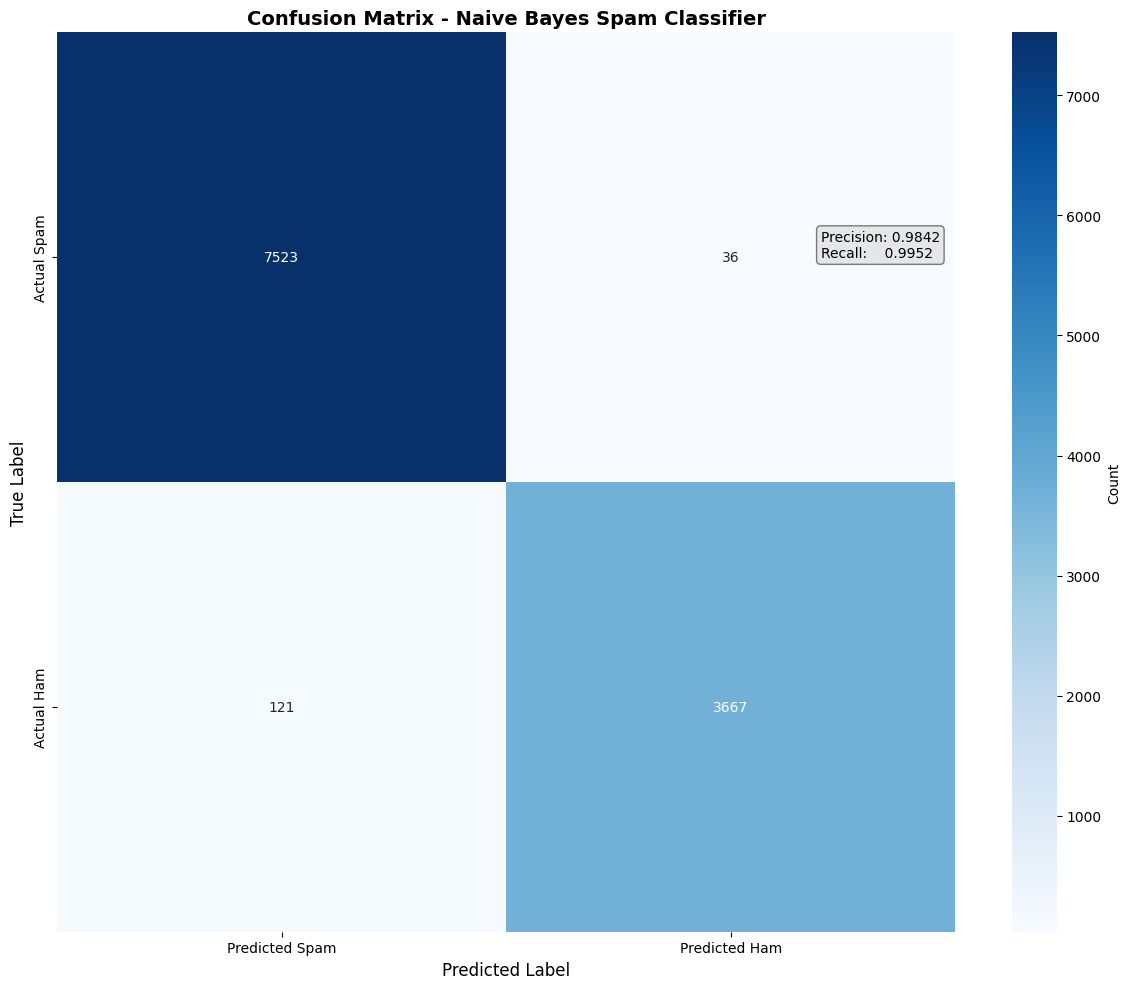

Confusion Matrix:
True Positives (TP): 7523
False Positives (FP): 121
False Negatives (FN): 36
True Negatives (TN): 3667


In [26]:
nb.plot_confusion_matrix(results)

## Lambda Smoothing

Without lambda, if there is a word that is not in the training vocabulary, then it's count for that class will be equivalent to 0. Then its likelihood will become 0. So we will test on the lambdas [0.005, 0.1, 0.5, 1.0, 2.0]

In [27]:
lambdas = [0.005, 0.1,0.25, 0.5,2.0]

In [28]:
results_lmbd = nb.evaluate_many_lambdas(lambdas, test_texts, test_labels)

for lam, metrics in results_lmbd.items():
    print(f"λ={lam:<6} Precision={metrics['precision']:.4f}  Recall={metrics['recall']:.4f}")


--- Evaluating lambda = 0.005 ---

--- Evaluating lambda = 0.1 ---

--- Evaluating lambda = 0.25 ---

--- Evaluating lambda = 0.5 ---

--- Evaluating lambda = 2.0 ---
λ=0.005  Precision=0.9899  Recall=0.9865
λ=0.1    Precision=0.9960  Recall=0.9868
λ=0.25   Precision=0.9944  Recall=0.9907
λ=0.5    Precision=0.9901  Recall=0.9931
λ=2.0    Precision=0.9784  Recall=0.9970


## Hovold's Paper

It is common to apply some form of attribute selection process, retaining only a subset of the words – or rather tokens, since punctuation signs and other symbols are often included found in the training messages. This way the learning and classification process may be sped up and memory requirements are lowered. Attribute selection may also lead to increased classification performance since, for example, the risk of overfitting the training data is reduced.

Removing Infrequent Words and Frequent Words, 
Removing tokens occurring less than three times seems to be a good trade-off between memory usage and classification performance,

In [29]:
def filter_vocabulary_hovold(spam_counts, ham_counts,min_freq=3,top_fraction=0.01):
    # --- Combine spam + ham counts ---
    total_counts = Counter()
    for w in set(spam_counts) | set(ham_counts):
        total_counts[w] = spam_counts.get(w, 0) + ham_counts.get(w, 0)

    original_vocab_size = len(total_counts)

    # --- 1. Remove rare words ---
    rare_removed = {w for w,f in total_counts.items() if f <= min_freq}

    # Keep only candidates that survive rare filter
    surviving_items = [(w,f) for w,f in total_counts.items() if f > min_freq]

    # --- 2. Remove the top fraction of frequent words ---
    surviving_items.sort(key=lambda x: x[1], reverse=True)
    cutoff = max(1, int(len(surviving_items) * top_fraction))
    high_removed = {w for w,_ in surviving_items[:cutoff]}

    # --- Final vocabulary ---
    filtered_vocab = set(w for w,_ in surviving_items) - high_removed

    removed_stats = {
        "original_vocab_size": original_vocab_size,
        "filtered_vocab_size": len(filtered_vocab),
        "removed_too_infrequent": len(rare_removed),
        "removed_too_frequent": len(high_removed),
        "top_removed_frequent": surviving_items[:20],     # inspect
        "sample_removed_infrequent": list(rare_removed)[:20]
    }
    return filtered_vocab, removed_stats


In [30]:
filtered_vocab, stats = filter_vocabulary_hovold(
    spam_counts,
    ham_counts,
    min_freq=3,     
    top_fraction=0.01
)

print(f"Original vocab:  {stats['original_vocab_size']:,}")
print(f"Filtered vocab:  {stats['filtered_vocab_size']:,}")
print(f"Removed rare:    {stats['removed_too_infrequent']:,}")
print(f"Removed frequent:{stats['removed_too_frequent']:,}")

Original vocab:  118,544
Filtered vocab:  49,944
Removed rare:    68,096
Removed frequent:504


In [31]:
spam_doc_counts2, ham_doc_counts2, num_spam_docs2, num_ham_docs2 = compute_counts(train_texts, train_labels, filtered_vocab)

In [32]:
nb_filtered = NaiveBayesClassifier(filtered_vocab, spam_doc_counts2, ham_doc_counts2, num_spam_docs2, num_ham_docs2, p_spam, p_ham, lam=1)
results_filtered = nb_filtered.evaluate(test_texts, test_labels)

Processed 567/11347 (5%)
Processed 1134/11347 (10%)
Processed 1701/11347 (15%)
Processed 2268/11347 (20%)
Processed 2835/11347 (25%)
Processed 3402/11347 (30%)
Processed 3969/11347 (35%)
Processed 4536/11347 (40%)
Processed 5103/11347 (45%)
Processed 5670/11347 (50%)
Processed 6237/11347 (55%)
Processed 6804/11347 (60%)
Processed 7371/11347 (65%)
Processed 7938/11347 (70%)
Processed 8505/11347 (75%)
Processed 9072/11347 (80%)
Processed 9639/11347 (85%)
Processed 10206/11347 (90%)
Processed 10773/11347 (95%)
Processed 11340/11347 (100%)




Precision: 0.9989
Recall   : 0.9742


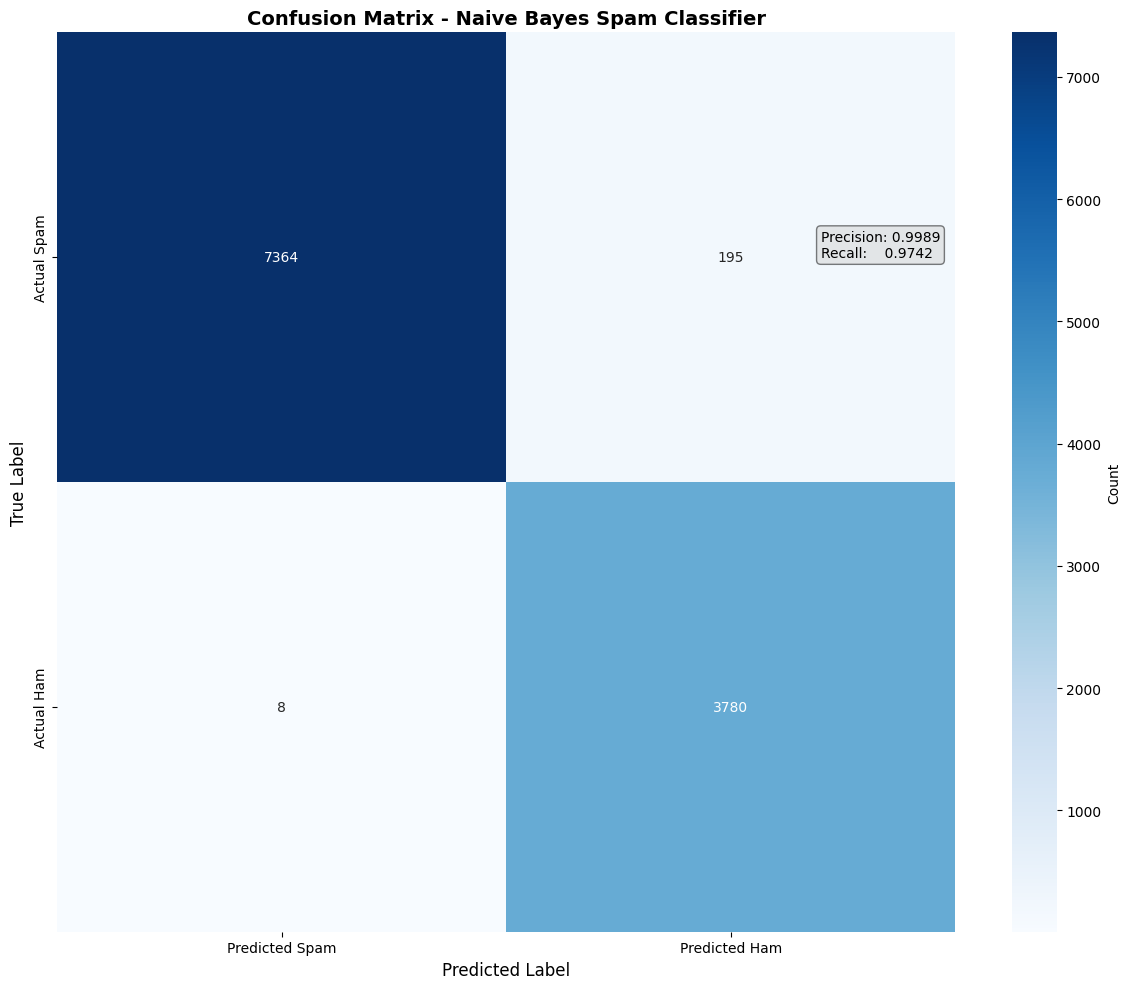

Confusion Matrix:
True Positives (TP): 7364
False Positives (FP): 8
False Negatives (FN): 195
True Negatives (TN): 3780


In [33]:
print("\n\nPrecision:", round(results_filtered["precision"], 4))
print("Recall   :", round(results_filtered["recall"], 4))

nb_filtered.plot_confusion_matrix(results_filtered)

In [34]:
results_lmbd_filtered = nb_filtered.evaluate_many_lambdas(lambdas, test_texts, test_labels)

for lam, metrics in results_lmbd_filtered.items():
    print(f"λ={lam:<6} Precision={metrics['precision']:.4f}  Recall={metrics['recall']:.4f}")


--- Evaluating lambda = 0.005 ---

--- Evaluating lambda = 0.1 ---

--- Evaluating lambda = 0.25 ---

--- Evaluating lambda = 0.5 ---

--- Evaluating lambda = 2.0 ---
λ=0.005  Precision=0.9879  Recall=0.9833
λ=0.1    Precision=0.9944  Recall=0.9791
λ=0.25   Precision=0.9988  Recall=0.9772
λ=0.5    Precision=0.9992  Recall=0.9768
λ=2.0    Precision=0.9986  Recall=0.9741


## Mutual Information Feature Selection

Following Hovold's paper, we'll use Mutual Information (MI) to rank features and select the top 200 words. MI measures how much information a feature provides about the class label.

In [35]:
def compute_mutual_information(word, spam_doc_counts, ham_doc_counts, num_spam_docs, num_ham_docs):
    """
    Compute mutual information for a single word.
    MI(word, class) = sum over all combinations of P(word, class) * log(P(word, class) / (P(word) * P(class)))
    """
    total_docs = num_spam_docs + num_ham_docs
    
    # Document counts
    spam_with_word = spam_doc_counts.get(word, 0)
    ham_with_word = ham_doc_counts.get(word, 0)
    spam_without_word = num_spam_docs - spam_with_word
    ham_without_word = num_ham_docs - ham_with_word
    
    # Probabilities
    p_spam = num_spam_docs / total_docs
    p_ham = num_ham_docs / total_docs
    
    # Joint and marginal probabilities
    p_word_spam = spam_with_word / total_docs
    p_word_ham = ham_with_word / total_docs
    p_no_word_spam = spam_without_word / total_docs
    p_no_word_ham = ham_without_word / total_docs
    
    p_word = (spam_with_word + ham_with_word) / total_docs
    p_no_word = 1 - p_word
    
    # Compute MI (handle log(0) by adding small epsilon)
    epsilon = 1e-10
    mi = 0
    
    # Word present, spam
    if p_word_spam > 0:
        mi += p_word_spam * math.log((p_word_spam + epsilon) / ((p_word + epsilon) * (p_spam + epsilon)))
    
    # Word present, ham
    if p_word_ham > 0:
        mi += p_word_ham * math.log((p_word_ham + epsilon) / ((p_word + epsilon) * (p_ham + epsilon)))
    
    # Word absent, spam
    if p_no_word_spam > 0:
        mi += p_no_word_spam * math.log((p_no_word_spam + epsilon) / ((p_no_word + epsilon) * (p_spam + epsilon)))
    
    # Word absent, ham
    if p_no_word_ham > 0:
        mi += p_no_word_ham * math.log((p_no_word_ham + epsilon) / ((p_no_word + epsilon) * (p_ham + epsilon)))
    
    return mi


def select_features_by_mutual_information(filtered_vocab, spam_doc_counts, ham_doc_counts,num_spam_docs, num_ham_docs, top_k=200):
    """
    Select top K features based on mutual information ranking.
    """
    print(f"Computing mutual information for {len(filtered_vocab):,} words...")
    
    # Compute MI for each word in filtered vocabulary
    word_mi_scores = []
    
    for i, word in enumerate(filtered_vocab):
        mi_score = compute_mutual_information(word, spam_doc_counts, ham_doc_counts, num_spam_docs, num_ham_docs)
        word_mi_scores.append((word, mi_score))
        
        # Progress indicator
        if (i + 1) % 5000 == 0:
            print(f"  Computed MI for {i + 1}/{len(filtered_vocab)} words...")
    
    # Sort by MI score (descending)
    word_mi_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Select top K words
    top_words = [word for word, score in word_mi_scores[:top_k]]
    
    print(f"\nSelected top {top_k} words by mutual information")
    print("\nTop 20 words by MI score:")
    for i in range(min(20, len(word_mi_scores))):
        word, score = word_mi_scores[i]
        print(f"  {i+1:3d}. {word:20s} MI: {score:.6f}")
    
    return set(top_words), word_mi_scores


# Select top 200 words using mutual information
mi_vocab_200, mi_scores = select_features_by_mutual_information(
    filtered_vocab, 
    spam_doc_counts2, 
    ham_doc_counts2,
    num_spam_docs2, 
    num_ham_docs2, 
    top_k=200
)

print(f"\nFinal vocabulary size: {len(mi_vocab_200)}")

Computing mutual information for 49,944 words...
  Computed MI for 5000/49944 words...
  Computed MI for 10000/49944 words...
  Computed MI for 15000/49944 words...
  Computed MI for 20000/49944 words...
  Computed MI for 25000/49944 words...
  Computed MI for 30000/49944 words...
  Computed MI for 35000/49944 words...
  Computed MI for 40000/49944 words...
  Computed MI for 45000/49944 words...

Selected top 200 words by mutual information

Top 20 words by MI score:
    1. ribbon               MI: 0.040512
    2. handy                MI: 0.038290
    3. seems                MI: 0.028185
    4. posted               MI: 0.026703
    5. output               MI: 0.025762
    6. input                MI: 0.025664
    7. robot                MI: 0.024777
    8. listprocessor        MI: 0.023594
    9. loop                 MI: 0.023005
   10. probably             MI: 0.022590
   11. motor                MI: 0.022142
   12. robotics             MI: 0.022131
   13. mst                  MI: 0.02

In [36]:
# Recompute document counts with only the top 200 MI-selected words
spam_doc_counts_mi200, ham_doc_counts_mi200, num_spam_docs_mi200, num_ham_docs_mi200 = compute_counts(
    train_texts, train_labels, mi_vocab_200
)

# Create classifier with MI-selected features
nb_mi200 = NaiveBayesClassifier(
    mi_vocab_200, 
    spam_doc_counts_mi200, 
    ham_doc_counts_mi200,
    num_spam_docs_mi200, 
    num_ham_docs_mi200, 
    p_spam, 
    p_ham, 
    lam=1
)

results_mi200 = nb_mi200.evaluate(test_texts, test_labels)

Processed 567/11347 (5%)
Processed 1134/11347 (10%)
Processed 1701/11347 (15%)
Processed 2268/11347 (20%)
Processed 2835/11347 (25%)
Processed 3402/11347 (30%)
Processed 3969/11347 (35%)
Processed 4536/11347 (40%)
Processed 5103/11347 (45%)
Processed 5670/11347 (50%)
Processed 6237/11347 (55%)
Processed 6804/11347 (60%)
Processed 7371/11347 (65%)
Processed 7938/11347 (70%)
Processed 8505/11347 (75%)
Processed 9072/11347 (80%)
Processed 9639/11347 (85%)
Processed 10206/11347 (90%)
Processed 10773/11347 (95%)
Processed 11340/11347 (100%)


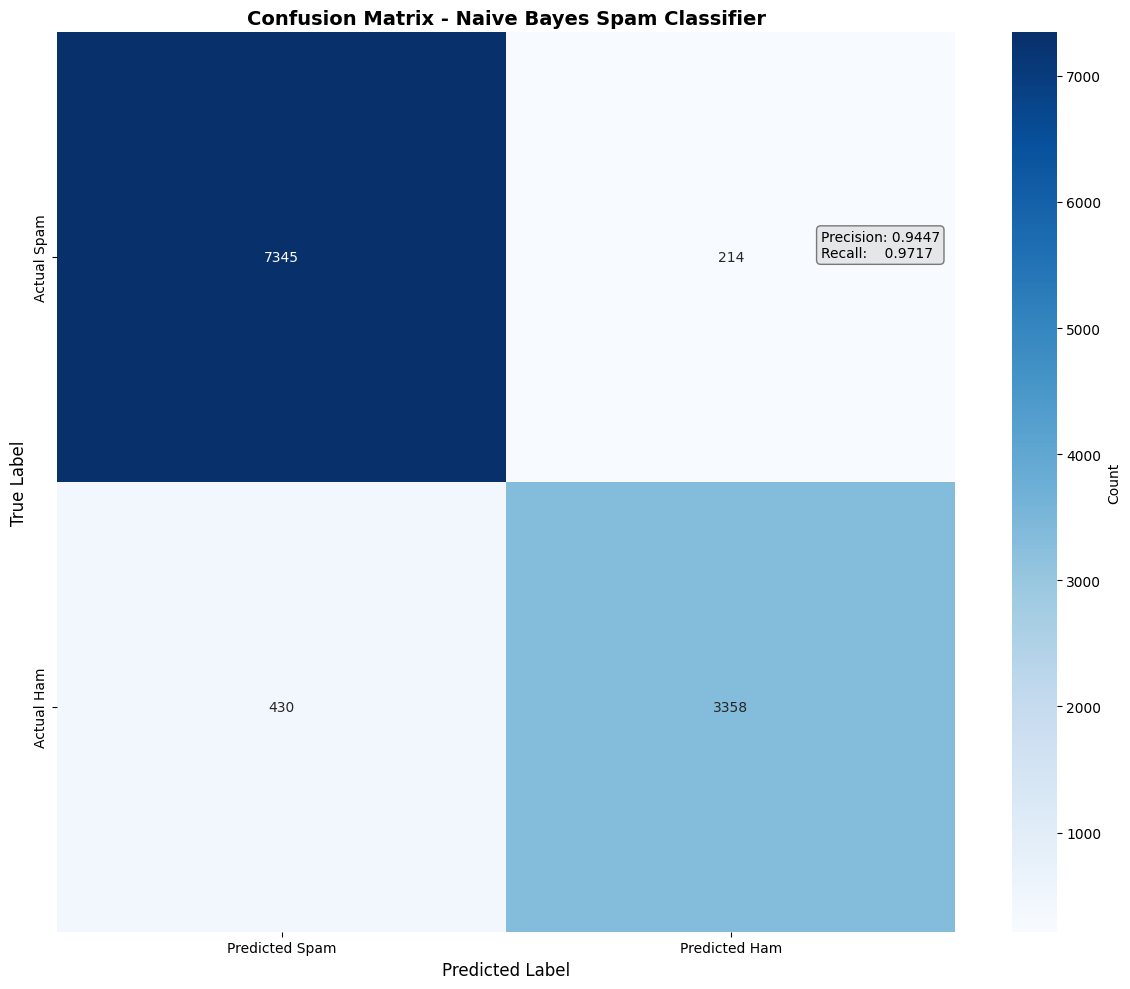

Confusion Matrix:
True Positives (TP): 7345
False Positives (FP): 430
False Negatives (FN): 214
True Negatives (TN): 3358


Precision: 0.9447
Recall   : 0.9717


In [37]:
nb_mi200.plot_confusion_matrix(results_mi200)

print("\n\nPrecision:", round(results_mi200["precision"], 4))
print("Recall   :", round(results_mi200["recall"], 4))


In [38]:
results_lmbd_mi200 = nb_mi200.evaluate_many_lambdas(lambdas, test_texts, test_labels)

for lam, metrics in results_lmbd_mi200.items():
    print(f"λ={lam:<6} Precision={metrics['precision']:.4f}  Recall={metrics['recall']:.4f}")


--- Evaluating lambda = 0.005 ---

--- Evaluating lambda = 0.1 ---

--- Evaluating lambda = 0.25 ---

--- Evaluating lambda = 0.5 ---

--- Evaluating lambda = 2.0 ---
λ=0.005  Precision=0.9456  Recall=0.9722
λ=0.1    Precision=0.9456  Recall=0.9721
λ=0.25   Precision=0.9457  Recall=0.9721
λ=0.5    Precision=0.9457  Recall=0.9717
λ=2.0    Precision=0.9452  Recall=0.9717


In [39]:
# Compare all results
print(f"Full vocabulary ({len(vocab):,} words):")
print(f"  Precision: {results['precision']:.4f}, Recall: {results['recall']:.4f}")

print(f"\nFiltered vocabulary ({len(filtered_vocab):,} words):")
print(f"  Precision: {results_filtered['precision']:.4f}, Recall: {results_filtered['recall']:.4f}")

print(f"\nTop 200 MI-selected words:")
print(f"  Precision: {results_mi200['precision']:.4f}, Recall: {results_mi200['recall']:.4f}")

Full vocabulary (118,544 words):
  Precision: 0.9842, Recall: 0.9952

Filtered vocabulary (49,944 words):
  Precision: 0.9989, Recall: 0.9742

Top 200 MI-selected words:
  Precision: 0.9447, Recall: 0.9717


In [40]:
# Visualize the selected words
print("\n" + "="*60)
print("ANALYSIS OF MI-SELECTED WORDS")
print("="*60)

# Show some examples of selected words
print("\nSample of selected words (sorted alphabetically):")
sorted_mi_words = sorted(list(mi_vocab_200))
for i in range(0, min(60, len(sorted_mi_words)), 6):
    row = sorted_mi_words[i:i+6]
    print("  " + ", ".join(f"{w:15}" for w in row))

# Analyze word characteristics
print("\n\nWord length distribution in MI-selected vocabulary:")
word_lengths = [len(w) for w in mi_vocab_200]
from collections import Counter
length_dist = Counter(word_lengths)
for length in sorted(length_dist.keys())[:10]:
    count = length_dist[length]
    print(f"  Length {length:2}: {count:3} words {'█' * (count // 2)}")

# Check which highly discriminative words made it
print("\n\nHighly discriminative words in top 200:")
discriminative_words = ['click', 'free', 'offer', 'money', 'viagra', 'pills', 
                        'edu', 'university', 'research', 'conference', 'paper']
found_words = []
for word in discriminative_words:
    if word in mi_vocab_200:
        found_words.append(word)

print(f"Found {len(found_words)}/{len(discriminative_words)} expected discriminative words:")
for word in found_words:
    # Find its MI score
    for w, score in mi_scores:
        if w == word:
            print(f"  - {word}: MI = {score:.6f}")
            break


ANALYSIS OF MI-SELECTED WORDS

Sample of selected words (sorted alphabetically):
  advance        , analog         , answer         , anybody        , anybodyi       , anything       
  anyway         , appears        , applications   , appreciated    , approved       , authors        
  awake          , basic          , bat            , beta           , bld            , built          
  chip           , circuit        , command        , comments       , connect        , connected      
  correct        , correctly      , couple         , cren           , daemon         , deagol         
  default        , depression     , device         , devmail        , diet           , digital        
  discreet       , dk             , done           , driver         , drivers        , either         
  else           , engineering    , enough         , envelope       , eudora         , example        
  experiment     , exploration    , ezmlm          , fat            , fine           , forster

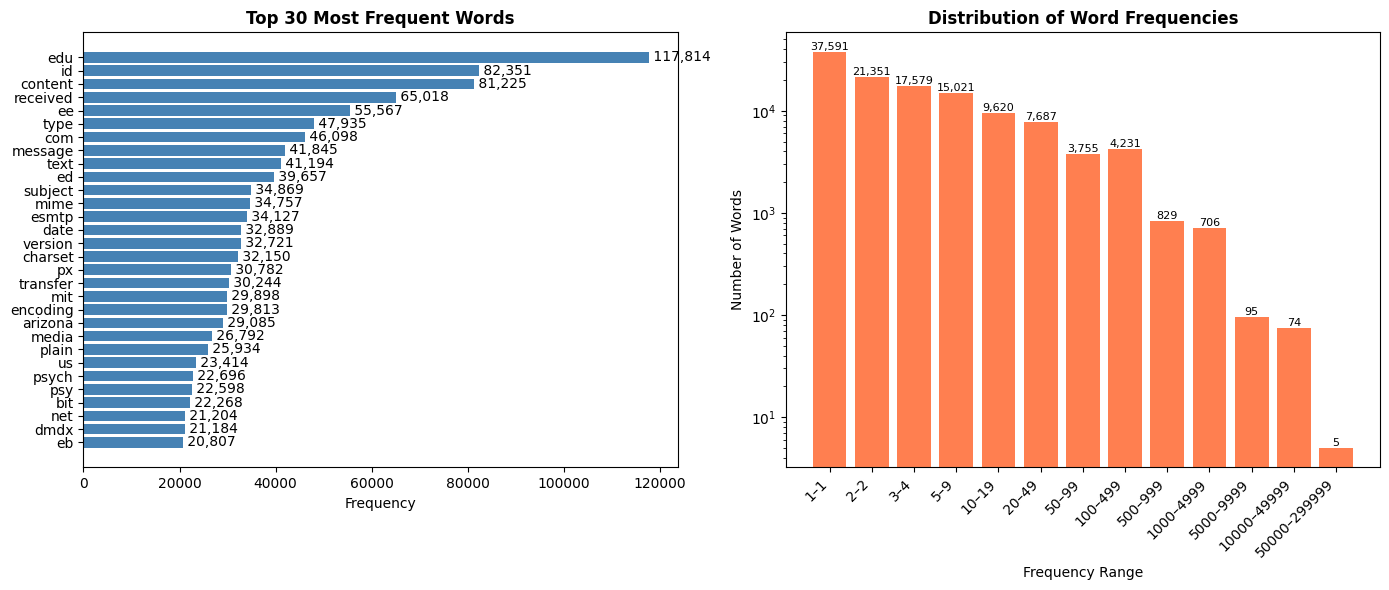

Total unique words : 118,544
Words appearing once : 37,591
Words appearing <3 times : 58,942


In [41]:
import matplotlib.pyplot as plt
from collections import Counter

# --- Combine spam and ham counts into total frequencies ---
total_word_counts = Counter()
for w in set(spam_counts) | set(ham_counts):
    total_word_counts[w] = spam_counts.get(w, 0) + ham_counts.get(w, 0)

# Sort words by overall frequency (descending)
sorted_word_freq = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)
all_freqs = [freq for _, freq in sorted_word_freq]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Top 30 Most Frequent Words
top_words = sorted_word_freq[:30]
words_top, freqs_top = zip(*top_words)

ax1.barh(range(len(words_top)), freqs_top, color="steelblue")
ax1.set_yticks(range(len(words_top)))
ax1.set_yticklabels(words_top)
ax1.set_xlabel("Frequency")
ax1.set_title("Top 30 Most Frequent Words", fontweight="bold")
ax1.invert_yaxis()
for i, v in enumerate(freqs_top):
    ax1.text(v, i, f" {v:,}", va="center")

# Distribution of Word Frequencies (Histogram, log scale)
freq_bins = [1, 2, 3, 5, 10, 20, 50, 100, 500, 1_000, 5_000, 10_000, 50_000, 300_000]
hist_data = []
labels = []
for i in range(len(freq_bins) - 1):
    count = sum(1 for f in all_freqs if freq_bins[i] <= f < freq_bins[i + 1])
    hist_data.append(count)
    labels.append(f"{freq_bins[i]}–{freq_bins[i + 1] - 1}")

ax2.bar(range(len(hist_data)), hist_data, color="coral")
ax2.set_xticks(range(len(hist_data)))
ax2.set_xticklabels(labels, rotation=45, ha="right")
ax2.set_ylabel("Number of Words")
ax2.set_xlabel("Frequency Range")
ax2.set_yscale("log")
ax2.set_title("Distribution of Word Frequencies", fontweight="bold")
for i, v in enumerate(hist_data):
    if v > 0:
        ax2.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

# Optional: print a few summary statistics
print(f"Total unique words : {len(total_word_counts):,}")
print(f"Words appearing once : {sum(1 for f in all_freqs if f == 1):,}")
print(f"Words appearing <3 times : {sum(1 for f in all_freqs if f < 3):,}")



ANALYSIS OF INFREQUENT WORDS

Sample of words appearing only ONCE (total: 37,591):
  blistering, mcpyw, tency, batuecas, faber, asai
  ideafest, dlbzstjzidpluyu, vbr, stegbth, pdwr, mchale
  odli, ush, probly, zhwkhh, mxms, jftyk
  asceticism, gnlfq, cative, unavoidably, uudecode, returnpath
  dini, klejner, uproarious, johna, pzi, losim

Sample of words appearing TWICE (total: 21,351):
  lukashenka, chalut, xinrbipdv, custmer, sash, xaba
  ebed, elea, profilepage, vlut, wsmg, unzp
  humes, layercamptools, efve, kilpatrick, flagd, edlia
  newnhot, buzzes, labonte, vno, astrounauts, qmmlwj
  pina, poderoso, kstoltz, ascleslie, lccurry, dmdmxh

Sample of words appearing 3-5 times (total: 21,798):
  determinations, cruftlabs, bri, rubbery, andoni, hymuww
  pondered, woolwich, mllilley, simplicicollis, remunerate, driverlinks
  twiggy, aprin, marinus, gqow, centrmmtao, bahija
  nishenko, solicitudes, viotxx, scot, sherbrooke, deve
  rechecked, poznanski, lexi, kitts, impulsar, souce


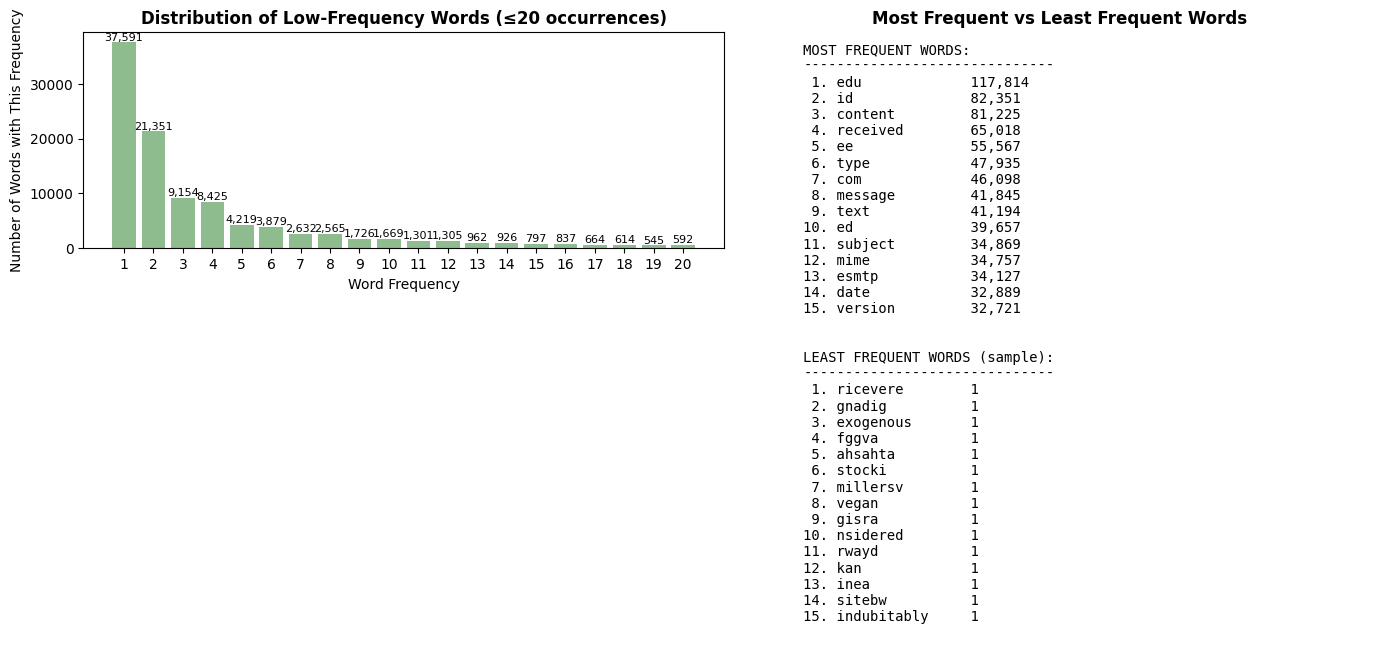

In [42]:
# Analyze infrequent words
print("\n" + "="*60)
print("ANALYSIS OF INFREQUENT WORDS")
print("="*60)

# Get words with specific frequencies
words_freq_1 = [word for word, freq in sorted_word_freq if freq == 1]
words_freq_2 = [word for word, freq in sorted_word_freq if freq == 2]
words_freq_3to5 = [word for word, freq in sorted_word_freq if 3 <= freq <= 5]

print(f"\nSample of words appearing only ONCE (total: {len(words_freq_1):,}):")
sample_1 = np.random.choice(words_freq_1, min(30, len(words_freq_1)), replace=False)
for i in range(0, len(sample_1), 6):
    print("  " + ", ".join(sample_1[i:i+6]))

print(f"\nSample of words appearing TWICE (total: {len(words_freq_2):,}):")
sample_2 = np.random.choice(words_freq_2, min(30, len(words_freq_2)), replace=False)
for i in range(0, len(sample_2), 6):
    print("  " + ", ".join(sample_2[i:i+6]))

print(f"\nSample of words appearing 3-5 times (total: {len(words_freq_3to5):,}):")
sample_3to5 = np.random.choice(words_freq_3to5, min(30, len(words_freq_3to5)), replace=False)
for i in range(0, len(sample_3to5), 6):
    print("  " + ", ".join(sample_3to5[i:i+6]))

# Visualization of the tail of the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of low frequencies
freq_distribution = Counter(all_freqs)
low_freqs = [(f, count) for f, count in freq_distribution.items() if f <= 20]
low_freqs.sort()

if low_freqs:
    freqs, counts = zip(*low_freqs)
    ax1.bar(range(len(freqs)), counts, color='darkseagreen')
    ax1.set_xticks(range(len(freqs)))
    ax1.set_xticklabels(freqs)
    ax1.set_xlabel('Word Frequency')
    ax1.set_ylabel('Number of Words with This Frequency')
    ax1.set_title('Distribution of Low-Frequency Words (≤20 occurrences)', fontweight='bold')
    for i, v in enumerate(counts):
        ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8)

# Most and least frequent words comparison
ax2.set_title('Most Frequent vs Least Frequent Words', fontweight='bold')
ax2.axis('off')

# Create text display
text_content = "MOST FREQUENT WORDS:\n" + "-"*30 + "\n"
for i, (word, freq) in enumerate(sorted_word_freq[:15]):
    text_content += f"{i+1:2d}. {word:15s} {freq:,}\n"

text_content += "\n\nLEAST FREQUENT WORDS (sample):\n" + "-"*30 + "\n"
sample_infrequent = sorted_word_freq[-15:]
for i, (word, freq) in enumerate(sample_infrequent):
    text_content += f"{i+1:2d}. {word:15s} {freq:,}\n"

ax2.text(0.1, 0.95, text_content, transform=ax2.transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()